# Self-Oranganizing Map / Auto-encodeur

## Tests avec notre dataset

In [361]:
# Open swiss data GeoDataFrame
import geopandas as gpd
import pandas as pd
import numpy as np

In [362]:
# Load the data
gdf = gpd.read_file('data/swiss_data_all.csv')

gdf.head()

,idx,geometry,altitude,TypoCH_NUM,Bodentyp,NAHRSTOFF,WASSERDURC,WASSERSPEI
0,35,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",363.5148,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0
1,36,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",358.93480000000005,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0
2,37,"POLYGON ((2485071.58 1111261.72, 2486071.58 11...",387.6868,12.0,-,-9999.0,-9999.0,-9999.0
3,261,"POLYGON ((2486071.58 1109261.72, 2487071.58 11...",415.6684,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0
4,262,"POLYGON ((2486071.58 1110261.72, 2487071.58 11...",368.5936,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0


In [363]:
# Add x and y columns to the GeoDataFrame
from shapely import wkt

gdf['geometry'] = gdf['geometry'].apply(wkt.loads)

In [364]:
gdf['x'] = None
gdf['y'] = None

for idx, row in gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    gdf.at[idx, 'x'] = x[0]
    gdf.at[idx, 'y'] = y[0]

In [365]:
gdf['altitude'] = gdf['altitude'].astype(float)
gdf['TypoCH_NUM'] = gdf['TypoCH_NUM'].astype(float)
gdf['NAHRSTOFF'] = gdf['NAHRSTOFF'].astype(float)
gdf['WASSERDURC'] = gdf['WASSERDURC'].astype(float)
gdf['WASSERSPEI'] = gdf['WASSERSPEI'].astype(float)

# Drop the geometry column
gdf = gdf.drop(columns='geometry')

In [366]:
# Étape 1 : Fractionner les chaînes de caractères en listes
gdf['Bodentyp_split'] = gdf['Bodentyp'].str.split('; ')

# Étape 2 : Identifier tous les mots uniques
all_labels = set(label.strip() for sublist in gdf['Bodentyp_split'] for label in sublist)

# Étape 3 : Créer des colonnes dummies
for label in all_labels:
    gdf["Bodentyp_"+label] = gdf['Bodentyp_split'].apply(lambda x: int(label in x))

# Supprimer la colonne temporaire si nécessaire
gdf = gdf.drop(columns=['Bodentyp_split'])
gdf = gdf.drop(columns=['Bodentyp'])
gdf = gdf.drop(columns=['idx'])

In [367]:
# Dummies TypoCH_NUM, NAHRSTOFF, WASSERDURC et WASSERSPEI
gdf = pd.get_dummies(gdf, columns=['TypoCH_NUM', 'NAHRSTOFF', 'WASSERDURC', 'WASSERSPEI'])

In [368]:
#Normalisation des données numériques
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

gdf[['altitude', 'x', 'y']] = scaler.fit_transform(gdf[['altitude', 'x', 'y']])

In [369]:
#Remove x and y columns
gdfWithoutCoordinate = gdf.drop(columns=['x', 'y'])

SOM code starts here

In [370]:
gdf.shape

(42444, 94)

In [371]:
from sklearn_som.som import SOM
import matplotlib.pyplot as plt

In [372]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(gdfWithoutCoordinate)
from sklearn.decomposition import PCA

In [390]:
som = SOM(m=25, n=25, dim=data_scaled.shape[1], lr=0.6, max_iter=2000, random_state=420)
som.fit(data_scaled) 

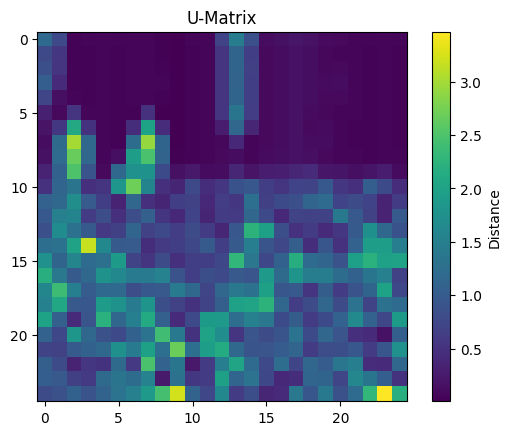

In [391]:
def plot_u_matrix(som):
    umatrix = np.zeros((som.m, som.n))
    for i in range(som.m):
        for j in range(som.n):
            # Calculate distances to neighbors
            neighbors = []
            if i > 0: neighbors.append(som.weights[i-1, j])
            if i < som.m-1: neighbors.append(som.weights[i+1, j])
            if j > 0: neighbors.append(som.weights[i, j-1])
            if j < som.n-1: neighbors.append(som.weights[i, j+1])
            # Average distance to neighbors
            umatrix[i, j] = np.mean([np.linalg.norm(som.weights[i, j] - n) for n in neighbors])

    # Plot as heatmap
    plt.imshow(umatrix, cmap='viridis')
    plt.colorbar(label='Distance')
    plt.title('U-Matrix')
    plt.show()

# Call the function
plot_u_matrix(som)

In [392]:
som.weights.shape

(625, 92)

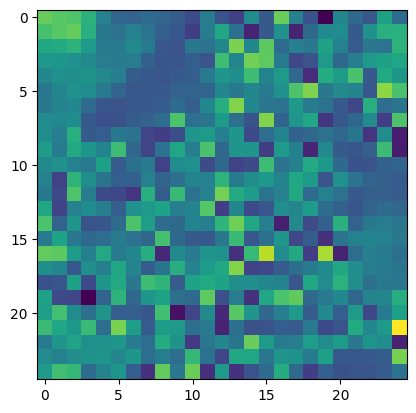

In [393]:
plt.imshow(np.reshape(som.weights[:,0], (25, 25)))

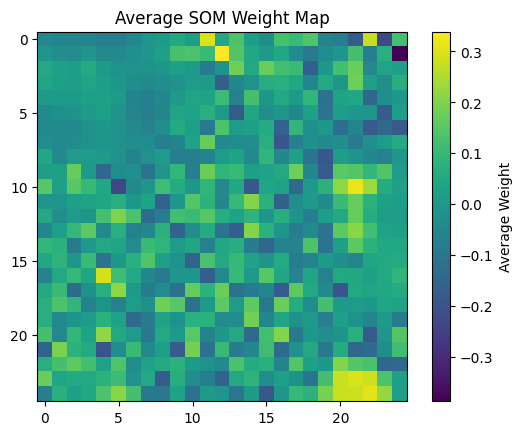

In [394]:
# Compute the average weights across all features
average_weights = np.mean(som.weights, axis=1)

# Reshape the average weights to the SOM grid shape
average_weights_reshaped = np.reshape(average_weights, (25, 25))

# Plot the average map
plt.imshow(average_weights_reshaped, cmap='viridis')
plt.colorbar(label='Average Weight')
plt.title('Average SOM Weight Map')
plt.show()

## SOM tests with the wine dataset

To figure out how it works

In [354]:
from sklearn.datasets import load_wine
wine = load_wine()

In [ ]:
wine = wine.data
wine.shape

In [356]:
m = 5
n = 5
wine_som = SOM(m=m, n=n, lr=0.5, dim=wine.shape[1])
wine_som.fit(wine)

In [ ]:
plot_u_matrix(wine_som)

In [ ]:
plt.imshow(np.reshape(wine_som.weights[:,0], (m, n)))

In [ ]:
# Compute the average weights across all features
average_wine_weights = np.mean(wine_som.weights, axis=1)

# Reshape the average weights to the SOM grid shape
average_wine_weights_reshaped = np.reshape(average_wine_weights, (m, n))

# Plot the average map
plt.imshow(average_wine_weights_reshaped, cmap='viridis')
plt.colorbar(label='Average Weight')
plt.title('Average SOM Weight Map')
plt.show()